##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic text classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multi-class classifier to predict the tag for a programming question on Stack Overflow.


In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [4]:
print(tf.__version__)

2.10.0


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.


### Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

In [5]:
# url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# dataset = tf.keras.utils.get_file("aclImdb_v1", url,
#                                     untar=True, cache_dir='.',
#                                     cache_subdir='')

# dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
dataset_dir = os.path.join(os.getcwd(), 'aclImdb')

In [6]:
os.listdir(dataset_dir)

['.DS_Store', 'imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [7]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [8]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [9]:
# remove_dir = os.path.join(train_dir, 'unsup')
# shutil.rmtree(remove_dir)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data. 

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set). 

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Metal device set to: Apple M1


2022-10-20 18:07:17.583260: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-20 18:07:17.583638: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

2022-10-20 18:07:17.663793: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section. 

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [12]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [13]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [14]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer. 

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: To prevent [training-testing skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [15]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling adapt (using the test set would leak information).

In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

2022-10-20 18:07:20.654627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Let's create a function to see the result of using this layer to preprocess some data.

In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [20]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [21]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create your neural network:

In [23]:
embedding_dim = 16

In [24]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, check out the [Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings) tutorial.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units. 
4. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [25]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [26]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


2022-10-20 18:07:23.203407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


623/625 [============================>.] - ETA: 0s - loss: 0.6631 - binary_accuracy: 0.6940

2022-10-20 18:07:36.161762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 14s 21ms/step - loss: 0.6629 - binary_accuracy: 0.6944 - val_loss: 0.6132 - val_binary_accuracy: 0.7772
Epoch 2/10
625/625 [==============================] - 10s 15ms/step - loss: 0.5421 - binary_accuracy: 0.8061 - val_loss: 0.4963 - val_binary_accuracy: 0.8238
Epoch 3/10
625/625 [==============================] - 9s 15ms/step - loss: 0.4346 - binary_accuracy: 0.8537 - val_loss: 0.4189 - val_binary_accuracy: 0.8476
Epoch 4/10
625/625 [==============================] - 9s 15ms/step - loss: 0.3648 - binary_accuracy: 0.8756 - val_loss: 0.3731 - val_binary_accuracy: 0.8604
Epoch 5/10
625/625 [==============================] - 9s 15ms/step - loss: 0.3181 - binary_accuracy: 0.8915 - val_loss: 0.3445 - val_binary_accuracy: 0.8662
Epoch 6/10
625/625 [==============================] - 9s 15ms/step - loss: 0.2833 - binary_accuracy: 0.9020 - val_loss: 0.3254 - val_binary_accuracy: 0.8710
Epoch 7/10
625/625 [==============================] - 9s 15ms/step 

### Creating a plot of accuracy over each epoch

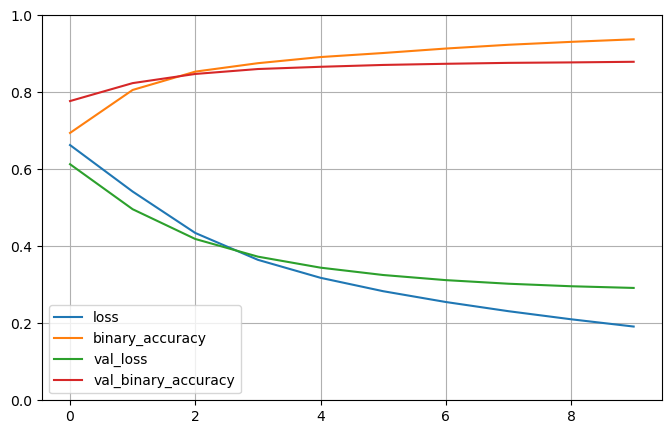

In [27]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In the plot, We mainly observe the binary accuracy "orange line" which represent training set and val_binary_accuracy "red line" which represent validation set. Clearly from the graph, it is visible that after epoch 2 model is undergoes 'overfitting'.

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [28]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 0.3103 - binary_accuracy: 0.8735
Loss:  0.31031689047813416
Accuracy:  0.8734800815582275


This fairly naive approach achieves an accuracy of about 87%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [29]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

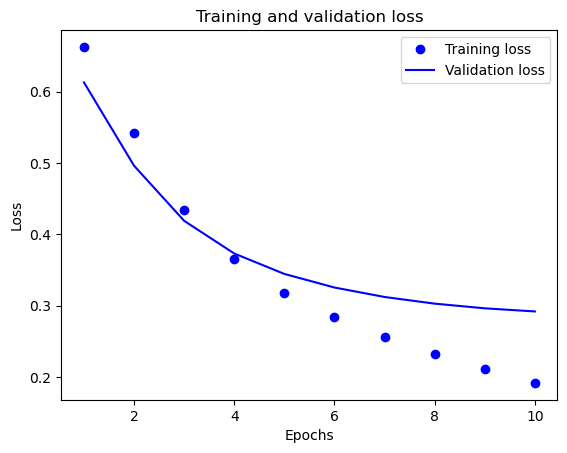

In [30]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

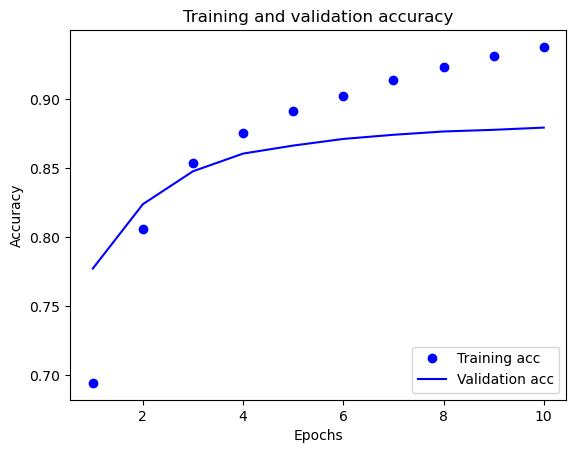

In [31]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the `tf.keras.callbacks.EarlyStopping` callback.

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [32]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

  8/782 [..............................] - ETA: 6s - loss: 0.3071 - accuracy: 0.8750  

2022-10-20 18:09:05.897751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 5s 6ms/step - loss: 0.3103 - accuracy: 0.8735
0.8734800815582275


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [33]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 191ms/step


2022-10-20 18:09:10.669792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[0.60691464],
       [0.4252106 ],
       [0.34096184]], dtype=float32)

In [34]:
OrigNN = model

In [35]:
def clear_backend_session():
    tf.keras.backend.clear_session()

## DenseNN Variant models

StudentId = 46312625, so N = 5 

### DenseNNi model

Dense hidden layer with (100 + 20 * N) neurons, which is 100 + 20*5 = 100 + 100 = 200 neurons

In [36]:
clear_backend_session()

DenseNNi = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(200),
    layers.Dense(1)
])

DenseNNi.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

DenseNNi.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 200)               3400      
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                        

In [37]:
epochs = 10
DenseNNi_history = DenseNNi.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


2022-10-20 18:09:11.084259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


622/625 [============================>.] - ETA: 0s - loss: 0.4690 - binary_accuracy: 0.7618

2022-10-20 18:09:24.162366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 14s 21ms/step - loss: 0.4681 - binary_accuracy: 0.7622 - val_loss: 0.3179 - val_binary_accuracy: 0.8680
Epoch 2/10
625/625 [==============================] - 11s 17ms/step - loss: 0.2253 - binary_accuracy: 0.9135 - val_loss: 0.3127 - val_binary_accuracy: 0.8698
Epoch 3/10
625/625 [==============================] - 10s 17ms/step - loss: 0.1292 - binary_accuracy: 0.9554 - val_loss: 0.3784 - val_binary_accuracy: 0.8634
Epoch 4/10
625/625 [==============================] - 10s 16ms/step - loss: 0.0631 - binary_accuracy: 0.9816 - val_loss: 0.4839 - val_binary_accuracy: 0.8610
Epoch 5/10
625/625 [==============================] - 10s 16ms/step - loss: 0.0306 - binary_accuracy: 0.9918 - val_loss: 0.5275 - val_binary_accuracy: 0.8762
Epoch 6/10
625/625 [==============================] - 10s 16ms/step - loss: 0.0225 - binary_accuracy: 0.9936 - val_loss: 0.6479 - val_binary_accuracy: 0.8762
Epoch 7/10
625/625 [==============================] - 10s 15ms/

### Evaluated model performance

In [38]:
loss_i, accuracy_i = DenseNNi.evaluate(test_ds)

print("Loss: ", loss_i)
print("Accuracy: ", accuracy_i)

782/782 [==============================] - 3s 4ms/step - loss: 1.0111 - binary_accuracy: 0.8525
Loss:  1.0110551118850708
Accuracy:  0.8525200486183167


Model achieve accuracy of 85%

### Plotting Accuracy and loss at each epoch

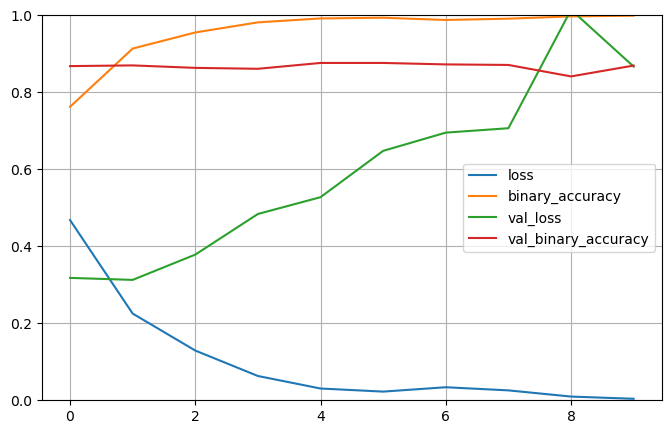

In [39]:
pd.DataFrame(DenseNNi_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In this plot, Orange line is training accuracy and Red line is validation accuracy. We would mainly focus on accuracy of the model, observing the plotted line at each epoch, training accuracy reachs it peak whereas validation accuracy doesn't, Clearly showing that model is still "overfitting".

## Performance Comparision between OrigNN and DenseNNi

|Epoch|Training Accuracy||Validation Accuracy||
---|---|---|---|---|
Model|OrigNN|DenseNNi|OrigNN|DenseNNi|
1st|69.79%|77.98%|77.16%|86.66%|
2nd|80.42%|91.94%|82.26%|87.12%|
3rd|85.05%|96.39%|84.54%|86.06%|
4th|87.47%|98.56%|85.96%|85.36%|
---|---|---|---|--|
---|---|---|---|--|
10th|93.70%|99.91%|87.94%|87.36%|


In the comparision table, Training Accuracy for OrigNN and DenseNNi from 1st epoch to last epoch increases when adding Dense hidden neurons after the dropout layer. As the model significantly gives higher and almost close to 100%, which indirectly also tell us there might be a possibilty that the model is been overfitting.

When observing Validation Accuracy for OrigNN and DenseNNi, at 1st epoch there is a difference in accuracy as it increase from 77% to 86% but reaching by last epoch the accuracy is similar.

When evaluting our model in test data, we get 

Model|OrigNN|DenseNNi|
---|---|---|
Accuracy|87%|85%|

The accuracy of the model has dropped from 87% to 85%, when adding dense layer neurons, Which also means that sometimes adding layers doesnot indicate that the model will have good accuracy of performs good. As in this case model seems to be overfitting or not learning.

### DenseNNii

Creating a dropout layer with hyperparameter D=0.3+0.05*N = 0.3+0.05*5 = 0.3+0.25 = 0.55, D=0.55


first dropout layer has hyperparameter 0.2 and the second has hyperparameter D

In [40]:
clear_backend_session()
DenseNNii = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.55),
    layers.Dense(200),
    layers.Dense(1)
])

DenseNNii.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 200)               3400      
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                        

In [41]:
DenseNNii.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

epochs = 10
DenseNNii_history = DenseNNii.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


2022-10-20 18:10:57.675387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


623/625 [============================>.] - ETA: 0s - loss: 0.5079 - binary_accuracy: 0.7364

2022-10-20 18:11:11.351670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 15s 22ms/step - loss: 0.5071 - binary_accuracy: 0.7369 - val_loss: 0.3323 - val_binary_accuracy: 0.8652
Epoch 2/10
625/625 [==============================] - 10s 16ms/step - loss: 0.2188 - binary_accuracy: 0.9181 - val_loss: 0.3040 - val_binary_accuracy: 0.8782
Epoch 3/10
625/625 [==============================] - 10s 15ms/step - loss: 0.0928 - binary_accuracy: 0.9716 - val_loss: 0.3575 - val_binary_accuracy: 0.8732
Epoch 4/10
625/625 [==============================] - 10s 15ms/step - loss: 0.0337 - binary_accuracy: 0.9904 - val_loss: 0.4256 - val_binary_accuracy: 0.8780
Epoch 5/10
625/625 [==============================] - 9s 15ms/step - loss: 0.0161 - binary_accuracy: 0.9960 - val_loss: 0.4905 - val_binary_accuracy: 0.8800
Epoch 6/10
625/625 [==============================] - 9s 14ms/step - loss: 0.0066 - binary_accuracy: 0.9984 - val_loss: 0.6775 - val_binary_accuracy: 0.8540
Epoch 7/10
625/625 [==============================] - 9s 15ms/ste

### DenseNNiii

first dropout layer has hyperparameter D and the second has hyperparameter 0.2

In [42]:
clear_backend_session()
DenseNNiii = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.55),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(200),
    layers.Dense(1)
])

DenseNNiii.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 200)               3400      
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                        

In [43]:
DenseNNiii.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

epochs = 10
DenseNNiii_history = DenseNNiii.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


2022-10-20 18:12:35.683427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - ETA: 0s - loss: 0.4883 - binary_accuracy: 0.7453

2022-10-20 18:12:49.316528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 15s 23ms/step - loss: 0.4883 - binary_accuracy: 0.7453 - val_loss: 0.3296 - val_binary_accuracy: 0.8600
Epoch 2/10
625/625 [==============================] - 11s 17ms/step - loss: 0.2038 - binary_accuracy: 0.9239 - val_loss: 0.3176 - val_binary_accuracy: 0.8698
Epoch 3/10
625/625 [==============================] - 10s 16ms/step - loss: 0.0793 - binary_accuracy: 0.9759 - val_loss: 0.3970 - val_binary_accuracy: 0.8664
Epoch 4/10
625/625 [==============================] - 10s 15ms/step - loss: 0.0276 - binary_accuracy: 0.9932 - val_loss: 0.4365 - val_binary_accuracy: 0.8776
Epoch 5/10
625/625 [==============================] - 9s 15ms/step - loss: 0.0151 - binary_accuracy: 0.9964 - val_loss: 0.5861 - val_binary_accuracy: 0.8728
Epoch 6/10
625/625 [==============================] - 9s 14ms/step - loss: 0.0126 - binary_accuracy: 0.9958 - val_loss: 0.7785 - val_binary_accuracy: 0.8558
Epoch 7/10
625/625 [==============================] - 9s 14ms/ste

### DenseNNiv

both dropout layers have hyperparameter D

In [44]:
clear_backend_session()
DenseNNiv = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.55),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.55),
    layers.Dense(200),
    layers.Dense(1)
])

DenseNNiv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 200)               3400      
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                        

In [45]:
DenseNNiv.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

epochs = 10
DenseNNiv_history = DenseNNiv.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


2022-10-20 18:14:13.848999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


623/625 [============================>.] - ETA: 0s - loss: 0.5325 - binary_accuracy: 0.7191

2022-10-20 18:14:29.620312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 17s 26ms/step - loss: 0.5319 - binary_accuracy: 0.7195 - val_loss: 0.3541 - val_binary_accuracy: 0.8510
Epoch 2/10
625/625 [==============================] - 9s 14ms/step - loss: 0.2126 - binary_accuracy: 0.9223 - val_loss: 0.3370 - val_binary_accuracy: 0.8524
Epoch 3/10
625/625 [==============================] - 9s 14ms/step - loss: 0.0686 - binary_accuracy: 0.9797 - val_loss: 0.3795 - val_binary_accuracy: 0.8622
Epoch 4/10
625/625 [==============================] - 8s 13ms/step - loss: 0.0217 - binary_accuracy: 0.9953 - val_loss: 0.4034 - val_binary_accuracy: 0.8794
Epoch 5/10
625/625 [==============================] - 8s 13ms/step - loss: 0.0077 - binary_accuracy: 0.9985 - val_loss: 0.4500 - val_binary_accuracy: 0.8786
Epoch 6/10
625/625 [==============================] - 8s 13ms/step - loss: 0.0030 - binary_accuracy: 0.9996 - val_loss: 0.5071 - val_binary_accuracy: 0.8728
Epoch 7/10
625/625 [==============================] - 8s 13ms/step -

## Performance comparision for all DenseNN variants with OrigNN

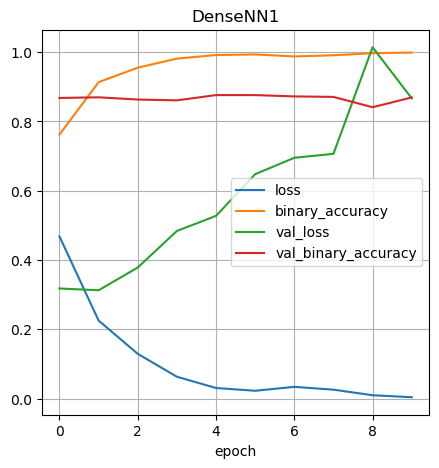

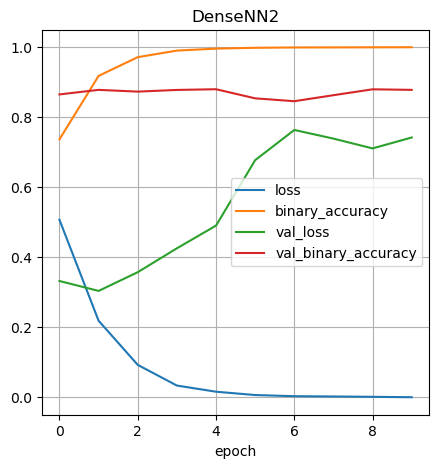

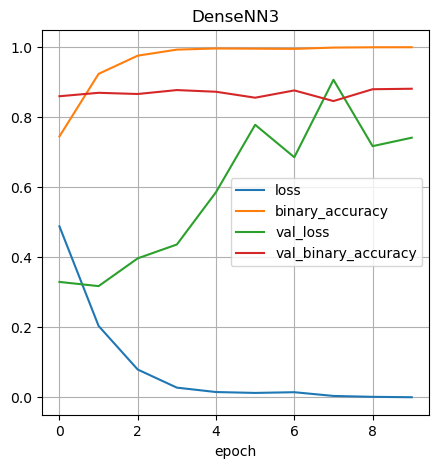

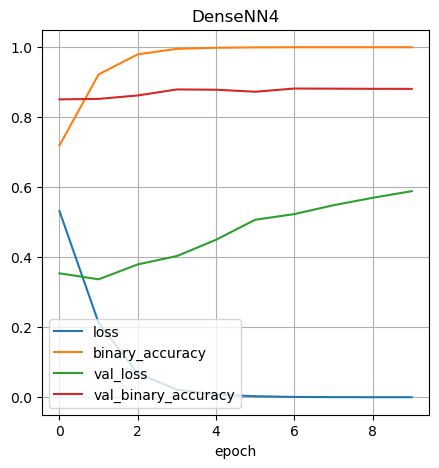

In [46]:
dense_model = [DenseNNi_history, DenseNNii_history, DenseNNiii_history, DenseNNiv_history]

for model_name in dense_model:
    pd.DataFrame(model_name.history).plot(figsize=(5, 5))
    plt.grid(True)
    plt.xlabel('epoch')
    plt.title('DenseNN'+str(dense_model.index(model_name)+1))
    plt.show()

In the above plot, Orange line is training accuracy and Red line is validation accuracy for all the models. Observing each epoch:

* For DenseNNi model, at Epoch 1 training_accuracy: 76.52% and validation_accuracy: 87.12%, epoch 2 shows us that the model is overfitting and not learning but remembering untill the last epoch were training_accuracy: 99.94% and validation_accuracy: 0.8712.

* For DenseNNii model, at Epoch 1 training_accuracy: 74.11% and validation_accuracy: 86.42%, epoch 2 shows us that the model is overfitting untill the last epoch were training_accuracy: 100% and validation_accuracy: 87.86%.

* For DenseNNiii model, at Epoch 1 training_accuracy: 74.51% and validation_accuracy: 86.06%, epoch 2 has training_accuracy: 92.35% and validation_accuracy: 86.92%. As there is almost 8% accuracy difference which also indicated that the model is overfitting untill the last epoch were training_accuracy: 100% and validation_accuracy: 88.08%.

* For DenseNNiv model, at Epoch 1 with training_accuracy: 71.83% and validation_accuracy: 85.88%,and the last epoch were training_accuracy: 100%(should not be possible) and validation_accuracy: 88.14%.

As for all the DenseNN variant Epoch 1 seems to be the best Epoch whereas for OrigNN model, the best epoch is Epoch 4 from model OrigNN training accuracy: 85.19% and validation accuracy: 84.72%, after that epoch the models suffers from overfitting.

**Best Epoch: 4 (Model:OrigNN)**

In [47]:
loss_ii, accuracy_ii = DenseNNii.evaluate(test_ds)

print("Loss: ", loss_ii)
print("Accuracy: ", accuracy_ii)

loss_iii, accuracy_iii = DenseNNiii.evaluate(test_ds)

print("Loss: ", loss_iii)
print("Accuracy: ", accuracy_iii)

loss_iv, accuracy_iv = DenseNNiv.evaluate(test_ds)

print("Loss: ", loss_iv)
print("Accuracy: ", accuracy_iv)

2022-10-20 18:15:45.354663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 3s 4ms/step - loss: 0.8025 - binary_accuracy: 0.8661
Loss:  0.8025274872779846
Accuracy:  0.8661200404167175


2022-10-20 18:15:48.801480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 3s 4ms/step - loss: 0.8280 - binary_accuracy: 0.8632
Loss:  0.8279601335525513
Accuracy:  0.8632000684738159
782/782 [==============================] - 3s 4ms/step - loss: 0.6329 - binary_accuracy: 0.8712
Loss:  0.6328527331352234
Accuracy:  0.8712400794029236


### Best model(so far): OrigNN 

Model|OrigNN|DenseNNi|DenseNNii|DenseNNiii|DenseNNiv
---|---|---|---|---|---|
Loss|0.31|0.99|0.78|0.80|0.63|
Accuracy|87%|85%|86%|86%|87%|

We would consider OrigNN to be the best model out of all as it have the lowest loss in when compared to all DenseNN varaint and also the best accuracy.

## CNN variants

kernel size K = (N / 2) + 5 = (5/2)+5 = 3.5~4 + 5 = 9, K =9

### CNNi

Both Dropout layer hyperparameters 0.2

In [48]:
clear_backend_session()
CNNi = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.Conv1D(128, kernel_size=9, padding="valid", activation="relu", strides=3),
    layers.Conv1D(128, kernel_size=9, padding="valid", activation="relu", strides=3),
    layers.GlobalMaxPooling1D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid", name="predictions")
])

CNNi.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         18560     
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         147584    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                        

In [49]:
CNNi.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

epochs = 10
CNNi_history = CNNi.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


/opt/miniconda3/envs/mlunit/lib/python3.9/site-packages/keras/backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2022-10-20 18:15:55.615045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


624/625 [============================>.] - ETA: 0s - loss: 0.4860 - binary_accuracy: 0.4978

2022-10-20 18:16:14.146015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 20s 30ms/step - loss: 0.4856 - binary_accuracy: 0.4981 - val_loss: 0.3357 - val_binary_accuracy: 0.5076
Epoch 2/10
625/625 [==============================] - 11s 18ms/step - loss: 0.2298 - binary_accuracy: 0.4981 - val_loss: 0.3550 - val_binary_accuracy: 0.5076
Epoch 3/10
625/625 [==============================] - 11s 18ms/step - loss: 0.1112 - binary_accuracy: 0.4981 - val_loss: 0.5722 - val_binary_accuracy: 0.5076
Epoch 4/10
625/625 [==============================] - 11s 18ms/step - loss: 0.0841 - binary_accuracy: 0.4981 - val_loss: 0.4607 - val_binary_accuracy: 0.5076
Epoch 5/10
625/625 [==============================] - 11s 17ms/step - loss: 0.0509 - binary_accuracy: 0.4981 - val_loss: 0.6071 - val_binary_accuracy: 0.5076
Epoch 6/10
625/625 [==============================] - 11s 17ms/step - loss: 0.0271 - binary_accuracy: 0.4981 - val_loss: 0.7277 - val_binary_accuracy: 0.5076
Epoch 7/10
625/625 [==============================] - 11s 17ms/

## CNNii

first dropout layer has hyperparameter 0.2 and the second has hyperparameter D

In [50]:
clear_backend_session()
CNNii = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.Conv1D(128, kernel_size=9, padding="valid", activation="relu", strides=3),
    layers.Conv1D(128, kernel_size=9, padding="valid", activation="relu", strides=3),
    layers.GlobalMaxPooling1D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.55),
    layers.Dense(1, activation="sigmoid", name="predictions")
])

CNNii.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         18560     
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         147584    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                        

In [51]:
CNNii.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

epochs = 10
CNNii_history = CNNii.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


2022-10-20 18:17:54.177134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


622/625 [============================>.] - ETA: 0s - loss: 0.4868 - binary_accuracy: 0.4976

2022-10-20 18:18:11.538290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 19s 28ms/step - loss: 0.4860 - binary_accuracy: 0.4981 - val_loss: 0.3359 - val_binary_accuracy: 0.5076
Epoch 2/10
625/625 [==============================] - 11s 17ms/step - loss: 0.2219 - binary_accuracy: 0.4981 - val_loss: 0.3506 - val_binary_accuracy: 0.5076
Epoch 3/10
625/625 [==============================] - 11s 17ms/step - loss: 0.1117 - binary_accuracy: 0.4981 - val_loss: 0.6024 - val_binary_accuracy: 0.5076
Epoch 4/10
625/625 [==============================] - 11s 17ms/step - loss: 0.0793 - binary_accuracy: 0.4981 - val_loss: 0.5107 - val_binary_accuracy: 0.5076
Epoch 5/10
625/625 [==============================] - 11s 17ms/step - loss: 0.0629 - binary_accuracy: 0.4981 - val_loss: 0.6072 - val_binary_accuracy: 0.5076
Epoch 6/10
625/625 [==============================] - 11s 17ms/step - loss: 0.0299 - binary_accuracy: 0.4981 - val_loss: 0.6070 - val_binary_accuracy: 0.5076
Epoch 7/10
625/625 [==============================] - 11s 17ms/

## CNNiii

first dropout layer has hyperparameter D and the second has hyperparameter 0.2

In [52]:
clear_backend_session()
CNNiii = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.55),
    layers.Conv1D(128, kernel_size=9, padding="valid", activation="relu", strides=3),
    layers.Conv1D(128, kernel_size=9, padding="valid", activation="relu", strides=3),
    layers.GlobalMaxPooling1D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid", name="predictions")
])

CNNiii.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         18560     
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         147584    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                        

In [53]:
CNNiii.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

epochs = 10
CNNiii_history = CNNiii.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


2022-10-20 18:19:47.928407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - ETA: 0s - loss: 0.5302 - binary_accuracy: 0.4981

2022-10-20 18:20:05.604951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 19s 29ms/step - loss: 0.5302 - binary_accuracy: 0.4981 - val_loss: 0.3997 - val_binary_accuracy: 0.5076
Epoch 2/10
625/625 [==============================] - 11s 18ms/step - loss: 0.2254 - binary_accuracy: 0.4981 - val_loss: 0.4072 - val_binary_accuracy: 0.5076
Epoch 3/10
625/625 [==============================] - 11s 18ms/step - loss: 0.0867 - binary_accuracy: 0.4981 - val_loss: 0.5151 - val_binary_accuracy: 0.5076
Epoch 4/10
625/625 [==============================] - 11s 18ms/step - loss: 0.0748 - binary_accuracy: 0.4981 - val_loss: 0.4479 - val_binary_accuracy: 0.5076
Epoch 5/10
625/625 [==============================] - 11s 17ms/step - loss: 0.0310 - binary_accuracy: 0.4981 - val_loss: 0.5787 - val_binary_accuracy: 0.5076
Epoch 6/10
625/625 [==============================] - 11s 17ms/step - loss: 0.0104 - binary_accuracy: 0.4981 - val_loss: 0.9342 - val_binary_accuracy: 0.5076
Epoch 7/10
625/625 [==============================] - 11s 17ms/

## CNNiv

both dropout layers have hyperparameter D

In [54]:
clear_backend_session()
CNNiv = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.55),
    layers.Conv1D(128, kernel_size=9, padding="valid", activation="relu", strides=3),
    layers.Conv1D(128, kernel_size=9, padding="valid", activation="relu", strides=3),
    layers.GlobalMaxPooling1D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.55),
    layers.Dense(1, activation="sigmoid", name="predictions")
])

CNNiv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         18560     
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         147584    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                        

In [55]:
CNNiv.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

epochs = 10
CNNiv_history = CNNiv.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


2022-10-20 18:21:45.080654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - ETA: 0s - loss: 0.5261 - binary_accuracy: 0.4981

2022-10-20 18:22:08.606588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 25s 38ms/step - loss: 0.5261 - binary_accuracy: 0.4981 - val_loss: 0.3591 - val_binary_accuracy: 0.5076
Epoch 2/10
625/625 [==============================] - 13s 20ms/step - loss: 0.2198 - binary_accuracy: 0.4981 - val_loss: 0.3777 - val_binary_accuracy: 0.5076
Epoch 3/10
625/625 [==============================] - 12s 19ms/step - loss: 0.0794 - binary_accuracy: 0.4981 - val_loss: 0.4981 - val_binary_accuracy: 0.5076
Epoch 4/10
625/625 [==============================] - 12s 19ms/step - loss: 0.0542 - binary_accuracy: 0.4981 - val_loss: 0.4639 - val_binary_accuracy: 0.5076
Epoch 5/10
625/625 [==============================] - 12s 19ms/step - loss: 0.0407 - binary_accuracy: 0.4981 - val_loss: 0.4612 - val_binary_accuracy: 0.5076
Epoch 6/10
625/625 [==============================] - 11s 18ms/step - loss: 0.0295 - binary_accuracy: 0.4981 - val_loss: 0.7009 - val_binary_accuracy: 0.5076
Epoch 7/10
625/625 [==============================] - 11s 18ms/

### Evaluting perfomance of each CNN Variant

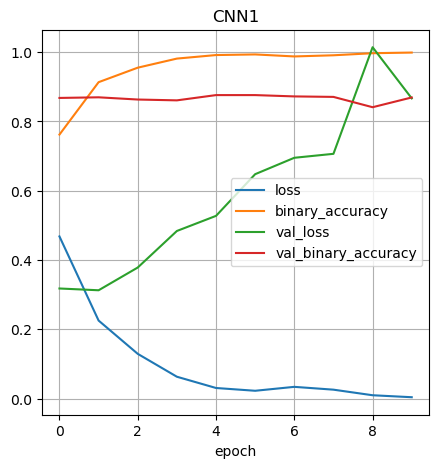

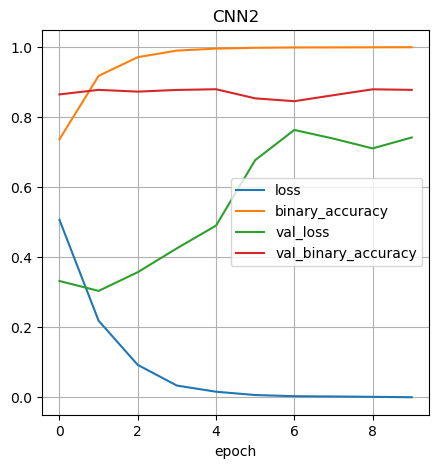

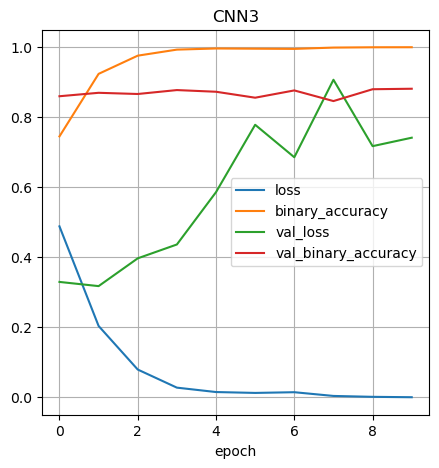

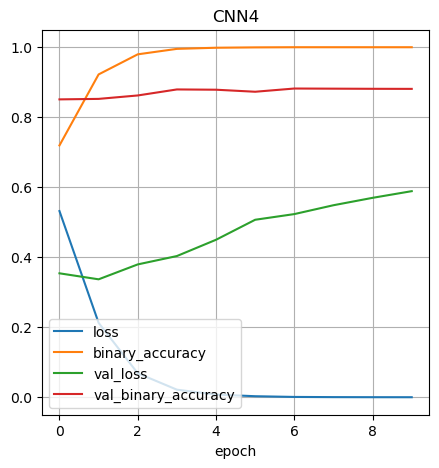

In [56]:
cnn_model = [CNNi_history, CNNii_history, CNNiii_history, CNNiv_history]

for model_name in dense_model:
    pd.DataFrame(model_name.history).plot(figsize=(5, 5))
    plt.grid(True)
    plt.xlabel('epoch')
    plt.title('CNN'+str(dense_model.index(model_name)+1))
    plt.show()

Model: CNNi

Epoch|Training accuracy|Validation Accuracy|
---|---|---|
1|49.81%|50.76%|
.|.|.|
.|.|.|
.|.|.|
9|49.81%|50.78%|
10|49.81%|50.76%|

Model: CNNii

Epoch|Training accuracy|Validation Accuracy|
---|---|---|
1|49.81%|50.76%|
.|.|.|
.|.|.|
.|.|.|
8|49.81%|50.78%|
9|49.82%|50.80%|
10|49.82%|50.76%|

Model: CNNiii

Epoch|Training accuracy|Validation Accuracy|
---|---|---|
1|49.81%|50.76%|
.|.|.|
.|.|.|
8|49.81%|50.78%|
.|.|.|
10|49.81%|50.78%|

Model: CNNiv

Epoch|Training accuracy|Validation Accuracy|
---|---|---|
1|49.81%|50.76%|
.|.|.|
.|.|.|
.|.|.|
8|49.82%|50.78%|
9|49.82%|50.78%|
10|49.83%|50.78%|

In the plot and summarizing epoch in the above table for CNN variants, we can observe that for 

* CNNi model: Epoch 1 to 8 has training accuracy of 49.81% and validation accuracy of 50.76% and as for epoch 9 there is only 0.02% increase in validation accuracy.

* CNNii model: Epoch 1 to 7 has training accuracy of 49.81% and validation accuracy of 50.76% and we do see an increase of validation accuracy for epoch 9, as for the last epoch model gives the same accuracy as before.

* CNNiii model: Epoch 1 to 7 has training accuracy of 49.81% and validation accuracy of 50.76%, as there is not much change in the model accuracy compared with previous model(i and ii). from the plot there is a **high loss of this model at epcoh 8**.

* CNNi model: Epoch 1 to 7 has training accuracy of 49.81% and validation accuracy of 50.76%. There is a slight increase in model training accuracy and validation accuracy form epcoh 8 which remains constant untill the last epoch. 

In [57]:
cnn_loss_i, cnn_accuracy_i = CNNi.evaluate(test_ds)

print("Loss: ", cnn_loss_i)
print("Accuracy: ", cnn_accuracy_i)

cnn_loss_ii, cnn_accuracy_ii = CNNii.evaluate(test_ds)

print("Loss: ", cnn_loss_ii)
print("Accuracy: ", cnn_accuracy_ii)

cnn_loss_iii, cnn_accuracy_iii = CNNiii.evaluate(test_ds)

print("Loss: ", cnn_loss_iii)
print("Accuracy: ", cnn_accuracy_iii)

cnn_loss_iv, cnn_accuracy_iv = CNNiv.evaluate(test_ds)

print("Loss: ", cnn_loss_iv)
print("Accuracy: ", cnn_accuracy_iv)

2022-10-20 18:23:52.967589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 5s 6ms/step - loss: 1.2929 - binary_accuracy: 0.5000
Loss:  1.2929357290267944
Accuracy:  0.5000000596046448


2022-10-20 18:23:57.644636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 5s 6ms/step - loss: 1.0856 - binary_accuracy: 0.5000
Loss:  1.085633397102356
Accuracy:  0.5000000596046448


2022-10-20 18:24:02.392888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 4s 5ms/step - loss: 1.2351 - binary_accuracy: 0.5000
Loss:  1.2351109981536865
Accuracy:  0.5000000596046448
782/782 [==============================] - 4s 5ms/step - loss: 1.3121 - binary_accuracy: 0.5000
Loss:  1.3120672702789307
Accuracy:  0.5000000596046448


### Selecting Best CNN variant

Model|CNNi|CNNii|CNNiii|CNNiv
---|---|---|---|---|
Loss|1.06|1.30|0.99|1.63|
Accuracy|50%|50%|50%|50%|

Since every CNN model variant has 50% accuracy. We would observe the Loss as CNNiii has the lowest loss among all CNN models, We would consider **CNNiii to be the best model**.

## Best model(so far): OrigNN

Comparing CNNii variant from CNN models, DenseNNiv variant from DenseNN models and OrigNN model

Model|OrigNN|Denseiv|CNNiii|
---|---|---|---|
Loss|0.31|0.63|0.99|
Accuracy|87%|87%|50%|

We would consider **OrigNN to be the best model** out of all as it have the lowest loss in when compared to all DenseNN varaint and CNN variant and also the best accuracy.

## NNBest

Since OrigNN is the best model so far NNbest would be OrigNN.

In [58]:
NNBest = OrigNN

NNBest.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

Training and dividing the model on subsets of the original training data of sizes (20%, 40%, 60%, 80%, 100%).

In [59]:
training_data_size = [0.8,0.6,0.4,0.2,1]

trainingsize_loss = []
trainingsize_accuracy = []
trainingsize_history = []

for size in training_data_size:
    if size == 1:
        raw_training_set = tf.keras.utils.text_dataset_from_directory(
            'aclImdb/train', 
            batch_size=batch_size, 
#             validation_split=100, 
#             subset='training', 
            seed=seed)
    else:
        raw_training_set = tf.keras.utils.text_dataset_from_directory(
            'aclImdb/train', 
            batch_size=batch_size, 
            validation_split=size, 
            subset='training', 
            seed=seed)
        
    training_ds = raw_training_set.map(vectorize_text)
    AUTOTUNE = tf.data.AUTOTUNE
    training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)

    history = NNBest.fit(
        training_ds,
        validation_data=val_ds,
        epochs=epochs)

    orignn_loss, orignn_accuracy = NNBest.evaluate(test_ds)
    
    trainingsize_history.append(history)
    trainingsize_loss.append(orignn_loss)
    trainingsize_accuracy.append(orignn_accuracy*100)

Found 25000 files belonging to 2 classes.
Using 5000 files for training.
Epoch 1/10


2022-10-20 18:24:12.238904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - ETA: 0s - loss: 0.2200 - binary_accuracy: 0.9218

2022-10-20 18:24:21.579852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 10s 62ms/step - loss: 0.2200 - binary_accuracy: 0.9218 - val_loss: 0.2909 - val_binary_accuracy: 0.8814
Epoch 2/10
157/157 [==============================] - 4s 23ms/step - loss: 0.2028 - binary_accuracy: 0.9302 - val_loss: 0.2898 - val_binary_accuracy: 0.8796
Epoch 3/10
157/157 [==============================] - 3s 21ms/step - loss: 0.1882 - binary_accuracy: 0.9398 - val_loss: 0.2892 - val_binary_accuracy: 0.8802
Epoch 4/10
157/157 [==============================] - 3s 20ms/step - loss: 0.1752 - binary_accuracy: 0.9480 - val_loss: 0.2889 - val_binary_accuracy: 0.8804
Epoch 5/10
157/157 [==============================] - 3s 19ms/step - loss: 0.1633 - binary_accuracy: 0.9540 - val_loss: 0.2889 - val_binary_accuracy: 0.8810
Epoch 6/10
157/157 [==============================] - 3s 19ms/step - loss: 0.1523 - binary_accuracy: 0.9596 - val_loss: 0.2891 - val_binary_accuracy: 0.8802
Epoch 7/10
157/157 [==============================] - 3s 18ms/step -

Epoch 9/10
782/782 [==============================] - 12s 15ms/step - loss: 0.0264 - binary_accuracy: 0.9954 - val_loss: 0.1523 - val_binary_accuracy: 0.9430
Epoch 10/10
782/782 [==============================] - 3s 4ms/step - loss: 0.5226 - binary_accuracy: 0.8524


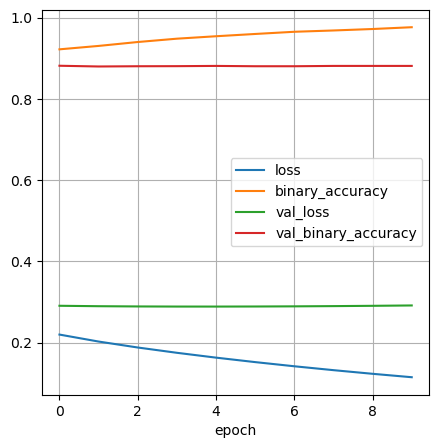

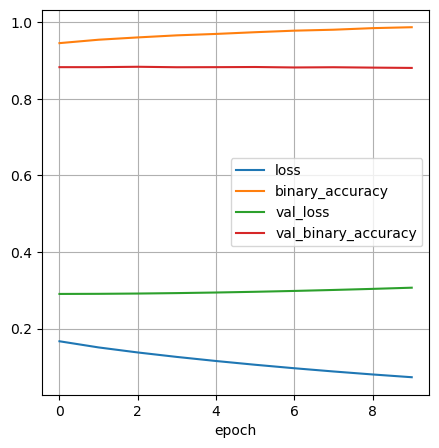

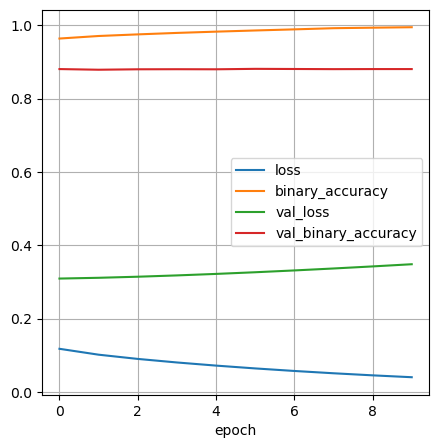

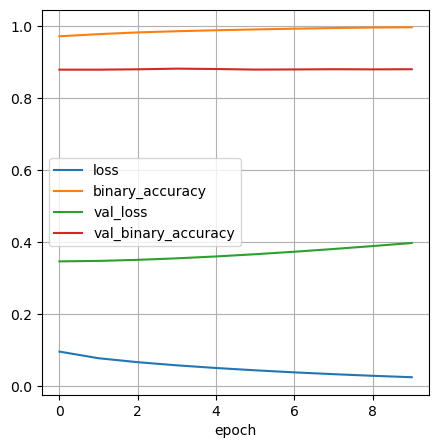

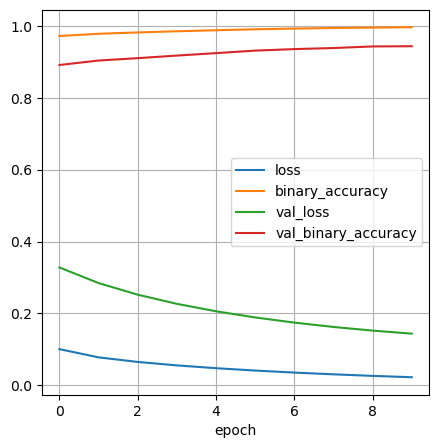

In [60]:
for model_name in trainingsize_history:
    pd.DataFrame(model_name.history).plot(figsize=(5, 5))
    plt.grid(True)
    plt.xlabel('epoch')
#     plt.title('CNN'+str(dense_model.index(model_name)+1))
    plt.show()

In [61]:
print(trainingsize_loss)
print(trainingsize_accuracy)

[0.31504377722740173, 0.3378826677799225, 0.3908321261405945, 0.4587806165218353, 0.5225890278816223]
[87.0080053806305, 86.58000826835632, 86.17600798606873, 85.77200770378113, 85.23600697517395]


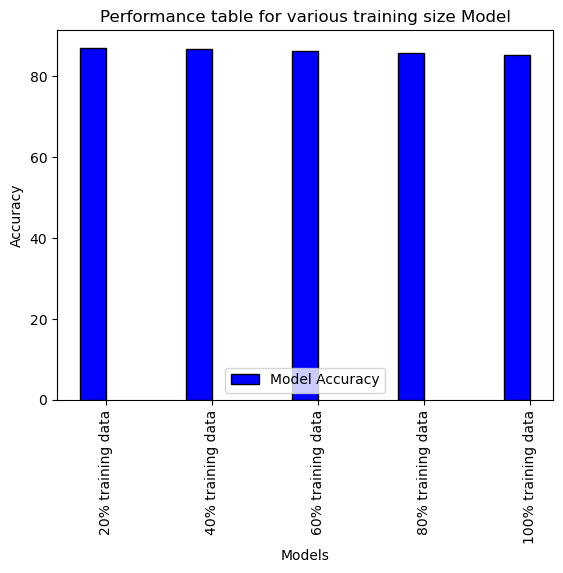

In [62]:
import numpy as np
import seaborn as sns

r = np.arange(len(trainingsize_accuracy))
width = 0.25

plt.bar(r, trainingsize_accuracy, color = 'b',
        width = width, edgecolor = 'black',
        label='Model Accuracy')
  
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Performance table for various training size Model")
  
plt.xticks(r + width/2,['20% training data', '40% training data', '60% training data', '80% training data',
         '100% training data'], rotation=90)
plt.legend()
  
plt.show()

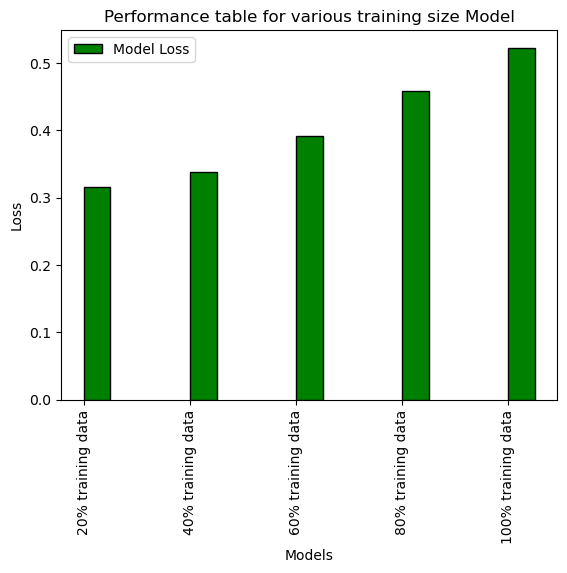

In [63]:
r = np.arange(len(trainingsize_loss))
width = 0.25

plt.bar(r + width, trainingsize_loss, color = 'g',
        width = width, edgecolor = 'black',
        label='Model Loss')
  
plt.xlabel("Models")
plt.ylabel("Loss")
plt.title("Performance table for various training size Model")
  
plt.xticks(r + width/2,['20% training data', '40% training data', '60% training data', '80% training data',
         '100% training data'], rotation=90)
plt.legend()
  
plt.show()


Table on Test Data

Model(Training size)|20%|40%|60%|80%|100%|
---|---|---|---|---|---|
Loss|0.40|0.45|0.51|0.58|0.64|
Accuracy|85%|85%|84%|84%|83%|

From the plot and table, the important thing we obeserve is that When training size of the model is increasing loss of the model also increases whereas accuracy of the model decrease.

Model with 20% training size has the **least loss and highest accuracy(85%)**, and when plotting the each epoch training and validation accuracy has almost same values i.e. training set accuracy remains almost 99% and validation accuracy is 93%, which shows model is overfitting.

Model with 40% training size , **loss increases to 0.45 but accuracy is same 85%** and plotting each epoch training set accuracy is going close to 100% and validation set **accuracy keep dereasing at each epoch**, shows "overfitting".

Model with 60% and 80% training size, **loss increases 0.51 and 0.58 and accuracy 84%** respectivily for both the models. As for each epoch we can see model is overfitting; i.e. for training set model accuracy is close by 100% but so validation set model accuracy is dereasing.

Model with 100% training size, has the **highest loss of 0.64 and losest accruacy of 83%**. where as for each epoch we can observe that the model **validation accuracy is increasing**.


Looking by the trend of increasing loss and decreasing accuracy we can assume that assiging more values to training set does not necessary mean model will perform good, As all the above model show "overfitting"(leaving model with 100% training size). Although the best model among these 5 models is model with training set of 20% and validation set of 20%, with least loss and highest accuracy.

Note: validation set of for all the models are 20% of the dataset.

## NNBestDrop

Let 1st create a functional model for NNBest.

In [64]:
def training_mode(dropout_layer):
    with tf.keras.backend.learning_phase_scope(dropout_layer):
        models_history = model.fit(train_ds,
                                    validation_data=val_ds,
                                    epochs=epochs)
        return models_history

Epoch 1/10
  4/625 [..............................] - ETA: 22s - loss: 0.0530 - binary_accuracy: 0.9688

/opt/miniconda3/envs/mlunit/lib/python3.9/contextlib.py:119: UserWarning: `tf.keras.backend.learning_phase_scope` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  return next(self.gen)


625/625 [==============================] - 12s 19ms/step - loss: 0.0634 - binary_accuracy: 0.9774 - val_loss: 0.1589 - val_binary_accuracy: 0.9384
Epoch 2/10
625/625 [==============================] - 2075s 3s/step - loss: 0.0448 - binary_accuracy: 0.9872 - val_loss: 0.1692 - val_binary_accuracy: 0.9342
Epoch 3/10
625/625 [==============================] - 1987s 3s/step - loss: 0.0366 - binary_accuracy: 0.9912 - val_loss: 0.1783 - val_binary_accuracy: 0.9326
Epoch 4/10
625/625 [==============================] - 2002s 3s/step - loss: 0.0310 - binary_accuracy: 0.9940 - val_loss: 0.1870 - val_binary_accuracy: 0.9310
Epoch 5/10
625/625 [==============================] - 2089s 3s/step - loss: 0.0266 - binary_accuracy: 0.9956 - val_loss: 0.1956 - val_binary_accuracy: 0.9276
Epoch 6/10
625/625 [==============================] - 1942s 3s/step - loss: 0.0229 - binary_accuracy: 0.9968 - val_loss: 0.2042 - val_binary_accuracy: 0.9268
Epoch 7/10
625/625 [==============================] - 10s 16ms/

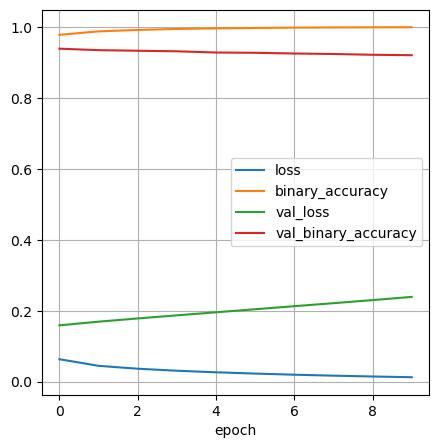

In [65]:
NNBest = training_mode(1)

pd.DataFrame(NNBest.history).plot(figsize=(5, 5))
plt.grid(True)
plt.xlabel('epoch')
plt.show()

Epoch 1/10
625/625 [==============================] - 9s 15ms/step - loss: 0.0109 - binary_accuracy: 0.9991 - val_loss: 0.2482 - val_binary_accuracy: 0.9188
Epoch 2/10
625/625 [==============================] - 20s 33ms/step - loss: 0.0093 - binary_accuracy: 0.9994 - val_loss: 0.2576 - val_binary_accuracy: 0.9174
Epoch 3/10
625/625 [==============================] - 32s 52ms/step - loss: 0.0080 - binary_accuracy: 0.9997 - val_loss: 0.2673 - val_binary_accuracy: 0.9164
Epoch 4/10
625/625 [==============================] - 94s 151ms/step - loss: 0.0068 - binary_accuracy: 0.9998 - val_loss: 0.2772 - val_binary_accuracy: 0.9156
Epoch 5/10
625/625 [==============================] - 10s 15ms/step - loss: 0.0058 - binary_accuracy: 0.9999 - val_loss: 0.2873 - val_binary_accuracy: 0.9142
Epoch 6/10
625/625 [==============================] - 108s 174ms/step - loss: 0.0049 - binary_accuracy: 1.0000 - val_loss: 0.2976 - val_binary_accuracy: 0.9130
Epoch 7/10
625/625 [==============================

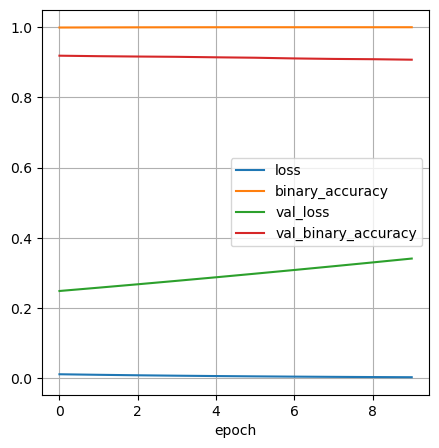

In [66]:
NNBestDrop = training_mode(0)

pd.DataFrame(NNBestDrop.history).plot(figsize=(5, 5))
plt.grid(True)
plt.xlabel('epoch')
plt.show()

In [67]:
NNBest_loss, NNBest_accuracy = NNBest.evaluate(test_ds)

print(NNBest_loss)
print(NNBest_accuracy)

NNBestDrop_loss, NNBestDrop_accuracy = NNBestDrop.evaluate(test_ds)

print(NNBestDrop_loss)
print(NNBestDrop_accuracy)

AttributeError: 'History' object has no attribute 'evaluate'

## Exercise: multi-class classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multi-class classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

A [dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) has been prepared for you to use containing the body of several thousand programming questions (for example, "How can I sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python. 

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: To increase the difficulty of the classification problem, occurrences of the words Python, CSharp, JavaScript, or Java in the programming questions have been replaced with the word *blank* (as many questions contain the language they're about).

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) that has already been prepared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications.

1. Modify the last layer of your model to `Dense(4)`, as there are now four output classes.

1. When compiling the model, change the loss to `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`. This is the correct loss function to use for a multi-class classification problem, when the labels for each class are integers (in this case, they can be 0, *1*, *2*, or *3*). In addition, change the metrics to `metrics=['accuracy']`, since this is a multi-class classification problem (`tf.metrics.BinaryAccuracy` is only used for binary classifiers).

1. When plotting accuracy over time, change `binary_accuracy` and `val_binary_accuracy` to `accuracy` and `val_accuracy`, respectively.

1. Once these changes are complete, you will be able to train a multi-class classifier. 

## Learning more

This tutorial introduced text classification from scratch. To learn more about the text classification workflow in general, check out the [Text classification guide](https://developers.google.com/machine-learning/guides/text-classification/) from Google Developers.
